# Noiseless case

In [ ]:
import cupy as np
from tqdm import trange
import pickle

In [ ]:
# Const Values
value_range = np.array(list(range(1, 11)) + list(range(-10, 0)))

In [ ]:
def generate_A(M, N):
    """
        Given M & N, generate the mesureament matrix A and normalize the columns
    """
    A = np.random.normal(0, 1, (M, N))
    norm = np.linalg.norm(A, axis=0)
    return A / norm

In [ ]:
def generate_x(N, s):
    """
        Given N and the Sparsity s, return the sparse vector
    """
    x = np.zeros(N)
    indices = np.random.choice(list(range(N)), s, replace=False)
    random_values = [np.random.choice([np.random.uniform(-10, -1), np.random.uniform(1, 10)], 1)[0] for _ in range(s)]
    x[indices] = random_values
    return x

In [ ]:
def OMP(y, A):
    """
        Main loop for the Othorgonal Matching Pursuit algorithm. 
        Given y and A, return the sparse result of x.
    """
    M = A.shape[0]
    N = A.shape[1]
    
    # Inital Residual is equal to the signal y
    r = y
    # Inital approximation is 0
    v = np.zeros(N)
    
    span = np.zeros((M, 0))
    span_indices = []
    
    err = 100
    
    while err > 1e-3:
        inner_prods = np.abs(np.dot(r, A))
        selected_index = np.argmax(inner_prods)
        
        span = np.append(span, A[:, selected_index].reshape(-1, 1), axis=1)
        span_indices.append(selected_index)
    
        v = np.linalg.inv(span.transpose() @ span) @ span.transpose() @ y
        r = y - span @ v
        err = np.linalg.norm(y - span @ v)
        
    v_array = np.zeros(N)
    v_array[span_indices] = v
    return v_array

In [ ]:
def compute_normalized_error(x, v):
    return np.linalg.norm(x - v) / np.linalg.norm(x)

In [ ]:
def main_exp(N, repeat_times, step = 1, acc_mat = None, norm_mat = None):
    if acc_mat.all() == None:
        acc_mat = np.zeros((N + 1, N + 1))
    if norm_mat.all() == None:
        norm_mat = np.zeros((N + 1, N + 1))

    for M in range(1, N + 1, step):
        for s in range(1, N + 1, step):
            print(f"Current M: {M}, s_max: {s}")
            
            if norm_mat[M][s] != 0:
                print("Processed, skip!")
                continue
            
            recover_cnt = 0
            normalized_error = 0
            cnt = 0
            for t in trange(repeat_times):
                cnt += 1
                A = generate_A(M, N)
                x = generate_x(N, s)
                y = A @ x
                v = OMP(y, A)
                
                if np.linalg.norm(x - v) < 1e-2:
                    recover_cnt += 1
                normalized_error += compute_normalized_error(x, v)
            acc_mat[M][s] = recover_cnt / cnt
            
            # When the recover ratio is close to zero, stop increase s
            # if acc_mat[M][s] < 1e-2:
            #    break
            
            norm_mat[M][s] = normalized_error / cnt
    return acc_mat, norm_mat

In [ ]:
with open("./non_noise/acc_mat_100.pkl", "rb") as reader:
    acc_mat_100 = pickle.load(reader)
with open("./non_noise/err_mat_100.pkl", "rb") as reader:
    norm_mat_100 = pickle.load(reader)

In [ ]:
with np.cuda.Device(0):
    
    acc_mat = acc_mat

In [ ]:
acc_mat, norm_mat = main_exp(20, 800, 1, acc_mat, norm_mat)

In [ ]:
acc_mat_50, norm_mat_50 = main_exp(50, 500, 2, acc_mat_50, norm_mat_50)

In [ ]:
acc_mat_100, norm_mat_100 = main_exp(100, 800, 2, acc_mat_100, norm_mat_100)

In [ ]:
with open("./non_noise_fill/acc_mat_50.pkl", "wb") as writer:
    pickle.dump(acc_mat_50, writer)
with open("./non_noise_fill/norm_mat_50.pkl", "wb") as writer:
    pickle.dump(norm_mat_50, writer)

# Noisy Case: Sparsity Known

In [ ]:
def generate_n(M, sigma):
    n = np.random.normal(0, sigma, (M,))
    return n

In [ ]:
def noisy_OMP_p(y, A, s):
    """
        Main loop for the Othorgonal Matching Pursuit algorithm. 
        Given y and A, return the sparse result of x.
        The sparsity s is known, and stop the the itertation at step s.
    """
    M = A.shape[0]
    N = A.shape[1]
    
    # Inital Residual is equal to the signal y
    r = y
    # Inital approximation is 0
    v = np.zeros(N)
    
    span = np.zeros((M, 0))
    span_indices = []
    
    err = 100
    
    # iterate for s times
    for _ in range(s):
        inner_prods = np.abs(np.dot(r, A))
        selected_index = np.argmax(inner_prods)
        
        span = np.append(span, A[:, selected_index].reshape(-1, 1), axis=1)
        span_indices.append(selected_index)
    
        v = np.linalg.inv(span.transpose() @ span) @ span.transpose() @ y
        r = y - span @ v
        err = np.linalg.norm(y - span @ v)
        
    v_array = np.zeros(N)
    v_array[span_indices] = v
    return v_array

In [ ]:
def noise_main_exp_s(N, repeat_times, step = 1, sigma = 0.1):
    acc_mat = np.zeros((N + 1, N + 1))
    norm_mat = np.zeros((N + 1, N + 1))

    for M in range(1, N + 1, step):
        for s in range(1, N + 1, step):
            print(f"Current M: {M}, s_max: {s}")
            recover_cnt = 0
            normalized_error = 0
            cnt = 0
            for t in trange(repeat_times):
                cnt += 1
                A = generate_A(M, N)
                x = generate_x(N, s)
                n = generate_n(M, sigma)
                y = A @ x + n
                v = noisy_OMP_p(y, A, s)
                
                norm_err = compute_normalized_error(x, v)
                if norm_err < 1e-3:
                    recover_cnt += 1
                normalized_error += norm_err
            acc_mat[M][s] = recover_cnt / cnt
            print(acc_mat[M][s])
            
            # When the recover ratio is close to zero, stop increase s
            if acc_mat[M][s] < 1e-2:
                break
            
            norm_mat[M][s] = normalized_error / cnt
    return acc_mat, norm_mat

In [ ]:
acc_mat_noisy_s_20, norm_mat_noisy_s_20 = noise_main_exp_s(20, 1000, 1, 0.01)

In [ ]:
acc_mat_noisy_s_50, norm_mat_noisy_s_50 = noise_main_exp_s(50, 1000, 2, 0.01)

In [ ]:
acc_mat_noisy_s_100, norm_mat_noisy_s_100 = noise_main_exp_s(100, 1000, 3, 0.01)

In [ ]:
with open("./noisy_with_s/acc_mat_noisy_s_100_001.pkl", "wb") as writer:
    pickle.dump(acc_mat_noisy_s_100, writer)
with open("./noisy_with_s/norm_mat_noisy_s_100_001.pkl", "wb") as writer:
    pickle.dump(norm_mat_noisy_s_100, writer)

In [ ]:
acc_mat_noisy_s_20_l, norm_mat_noisy_s_20_l = noise_main_exp_s(20, 500, 1, 0.5)


In [ ]:
acc_mat_noisy_s_50_l, norm_mat_noisy_s_50_l = noise_main_exp_s(50, 2000, 1, 10)


In [ ]:
acc_mat_noisy_s_100_l, norm_mat_noisy_s_100_l = noise_main_exp_s(100, 2000, 1, 10)

In [ ]:
with open("./noisy_with_s/acc_mat_noisy_s_100_10.pkl", "wb") as writer:
    pickle.dump(acc_mat_noisy_s_100_l, writer)
with open("./noisy_with_s/norm_mat_noisy_s_100_10.pkl", "wb") as writer:
    pickle.dump(norm_mat_noisy_s_100_l, writer)

In [ ]:
acc_mat_noisy_s_20

# Noisy Case: Sparsity Unknown

In [ ]:
def noisy_OMP_n(y, A, n):
    """
        Main loop for the Othorgonal Matching Pursuit algorithm. 
        Given y and A, return the sparse result of x.
        The noise n is known, stop when the norm of error is fewer than the norm of error.
    """
    M = A.shape[0]
    N = A.shape[1]
    
    # Inital Residual is equal to the signal y
    r = y
    # Inital approximation is 0
    v = np.zeros(N)
    
    span = np.zeros((M, 0))
    span_indices = []
    
    err = 100
    n_norm = np.linalg.norm(n)
    
    while err > n_norm:
        inner_prods = np.abs(np.dot(r, A))
        selected_index = np.argmax(inner_prods)
        
        span = np.append(span, A[:, selected_index].reshape(-1, 1), axis=1)
        span_indices.append(selected_index)
    
        v = np.linalg.inv(span.transpose() @ span) @ span.transpose() @ y
        r = y - span @ v
        err = np.linalg.norm(y - span @ v)
        
    v_array = np.zeros(N)
    v_array[span_indices] = v
    return v_array

In [ ]:
def noise_main_exp_n(N, repeat_times, step = 1, sigma = 0.1):
    acc_mat = np.zeros((N + 1, N + 1))
    norm_mat = np.zeros((N + 1, N + 1))

    for M in range(1, N + 1, step):
        for s in range(1, N + 1, step):
            print(f"Current M: {M}, s_max: {s}")
            recover_cnt = 0
            normalized_error = 0
            cnt = 0
            for t in trange(repeat_times):
                cnt += 1
                A = generate_A(M, N)
                x = generate_x(N, s)
                n = generate_n(M, sigma)
                y = A @ x + n
                v = noisy_OMP_n(y, A, n)
                
                norm_err = compute_normalized_error(x, v)
                if norm_err < 1e-3:
                    recover_cnt += 1
                normalized_error += norm_err
            acc_mat[M][s] = recover_cnt / cnt
            
            # When the recover ratio is close to zero, stop increase s
            if acc_mat[M][s] < 1e-2:
                break
            
            norm_mat[M][s] = normalized_error / cnt
    return acc_mat, norm_mat

In [ ]:
acc_mat_noisy_n_20, norm_mat_noisy_n_20 = noise_main_exp_n(20, 1000, 1, 0.01)

In [ ]:
acc_mat_noisy_n_50, norm_mat_noisy_n_50 = noise_main_exp_n(50, 1000, 2, 0.01)

In [ ]:
acc_mat_noisy_n_100, norm_mat_noisy_n_100 = noise_main_exp_n(100, 1000, 3, 0.01)

In [ ]:
acc_mat_noisy_n_20_10, norm_mat_noisy_n_20_10 = noise_main_exp_n(20, 1000, 1, 10)

In [ ]:
acc_mat_noisy_n_50_10, norm_mat_noisy_n_50_10 = noise_main_exp_n(50, 1000, 1, 10)

In [ ]:
acc_mat_noisy_n_100_10, norm_mat_noisy_n_100_10 = noise_main_exp_n(100, 1000, 2, 1)

In [ ]:
with open("./noisy_with_n/acc_mat_noisy_s_100_10.pkl", "wb") as writer:
    pickle.dump(acc_mat_noisy_n_100_10, writer)
with open("./noisy_with_n/norm_mat_noisy_s_100_10.pkl", "wb") as writer:
    pickle.dump(norm_mat_noisy_n_100_10, writer)

# Image Recover

In [ ]:
import scipy.io
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
mat = scipy.io.loadmat('Homeworks_export\Data for HW3\Y1 Y2 Y3 and A1 A2 A3.mat')

## OMP Method

In [ ]:
def recover_image(A, y):
    y = np.array(y.reshape(-1))
    A = np.array(A)
    x = OMP(y, A)
    x = x.reshape(160, 90).transpose()
    normalized_x = (x - np.min(x)) / (np.max(x) - np.min(x))
    image = Image.fromarray(np.uint8(normalized_x.get() * 255))
    return image, x

In [ ]:
def count_sparsity(x):
    cnt = 0
    for e in x.reshape(-1):
        if e != 0:
            cnt += 1
    return cnt

In [ ]:
i1, x1 = recover_image(mat['A1'], mat['y1'])
i2, x2 = recover_image(mat['A2'], mat['y2'])
i3, x3 = recover_image(mat['A3'], mat['y3'])

In [ ]:
i1.save('pic1.png')
i2.save('pic2.png')
i3.save('pic3.png')


In [ ]:
print('A1 shape: {}, sparsity: {}'.format(mat['A1'].shape, count_sparsity(x1)))
print('A2 shape: {}, sparsity: {}'.format(mat['A2'].shape, count_sparsity(x2)))
print('A3 shape: {}, sparsity: {}'.format(mat['A3'].shape, count_sparsity(x3)))

## Least Squares Method

In [ ]:
import numpy

In [ ]:
def least_squares(A, y):
    A = numpy.array(A)
    y = numpy.array(y)
    x_t = numpy.linalg.solve(A.transpose() @ A, A.transpose() @ y)
    x = x_t.reshape(160, 90).transpose()
    normalized_x = (x - np.min(x)) / (np.max(x) - np.min(x))
    image = Image.fromarray(np.uint8(normalized_x * 255))
    return image, x_t

In [ ]:
i1_ls, x1_ls = least_squares(mat['A1'], mat['y1'])
i2_ls, x2_ls = least_squares(mat['A2'], mat['y2'])
i3_ls, x3_ls = least_squares(mat['A3'], mat['y3'])

In [ ]:
i1_ls.save('pic1_ls.png')
i2_ls.save('pic2_ls.png')
i3_ls.save('pic3_ls.png')

In [ ]:
mul = np.array(mat['A1'].transpose()) @ np.array(mat['A1'])

In [ ]:
inv = numpy.linalg.inv(mul)

In [ ]:
inv @ (mat['A1'].transpose() @ mat['A1'])

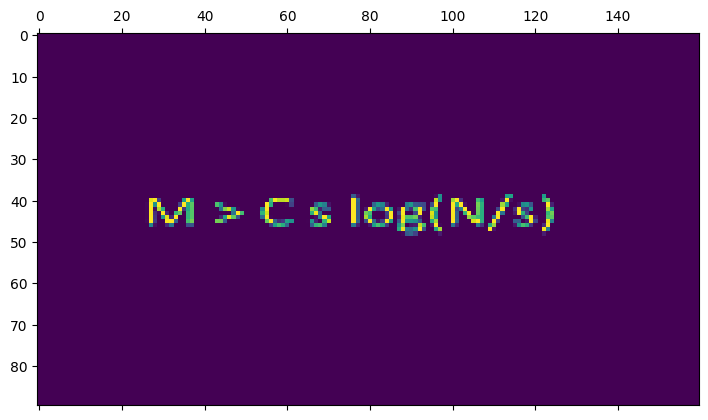

In [658]:
plt.matshow(x2.get().reshape(90, 160))

In [ ]:
mat['y1'].shape

In [ ]:
mat['y2'].shape

In [ ]:
mat['y3'].shape